# XGBoost Modeling for Employee Attrition

This notebook implements an end-to-end workflow for predicting employee attrition using XGBoost, including feature engineering, model training, evaluation, and interpretability.

---

## Imports

We begin by importing essential libraries for data manipulation, visualization, and evaluation.

In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
import shap

## Data Loading

Load the prepared HR employee attrition dataset for modeling. 

In [2]:
# Load the dataset
file_path = '../resources/data/output/hr_employee_attrition_prepared.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [4]:
df.shape

(1470, 31)

## Functions

The following helper functions are used for model evaluation and visualization:
- **plot_roc_curve**: Plots ROC curve and computes AUC for model discrimination.
- **plot_confusion_matrix**: Visualizes confusion matrix as a heatmap.
- **plot_metrics_comparison**: Compares base and tuned model metrics visually.

In [17]:
def plot_roc_curve(y_true, y_pred_proba):
    """
    Computes and plots the Receiver Operating Characteristic (ROC) curve.

    Args:
        y_true (array-like): True binary labels.
        y_pred_proba (array-like): Predicted probabilities for the positive class.
    """
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [18]:
def plot_confusion_matrix(y_true, y_pred, class_labels=['stay', 'left']):
    """
    Computes and plots a confusion matrix as a heatmap.

    Args:
        y_true (array-like): True binary labels.
        y_pred (array-like): Predicted binary labels.
        class_labels (list, optional): The labels for the classes. 
                                     Defaults to ['stay', 'left'].
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [19]:

def plot_metrics_comparison(report_base, report_tuned, roc_auc_base, roc_auc_tuned):
    """
    Compares and plots classification metrics for base and tuned models using Seaborn.

    Args:
        report_base (dict): Classification report for the base model.
        report_tuned (dict): Classification report for the tuned model.
        roc_auc_base (float): ROC AUC score for the base model.
        roc_auc_tuned (float): ROC AUC score for the tuned model.
    """
    # 1. Prepare the data in a long-form DataFrame
    metrics_data = []
    metrics_to_plot = ['precision', 'recall', 'f1-score']
    
    # Extract scores for the positive class
    for metric in metrics_to_plot:
        metrics_data.append({'Model': 'Base Model', 'Metric': metric, 'Score': report_base['1'][metric]})
        metrics_data.append({'Model': 'Tuned Model', 'Metric': metric, 'Score': report_tuned['1'][metric]})
    
    # Add ROC AUC scores
    metrics_data.append({'Model': 'Base Model', 'Metric': 'roc_auc', 'Score': roc_auc_base})
    metrics_data.append({'Model': 'Tuned Model', 'Metric': 'roc_auc', 'Score': roc_auc_tuned})
    
    df = pd.DataFrame(metrics_data)

    # 2. Create the plot using Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='Metric', y='Score', hue='Model', palette='viridis')

    # 3. Add score labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

    # 4. Final plot adjustments
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Score')
    ax.set_xlabel('Metric')
    ax.set_title('Comparison of Classification Metrics (Base vs. Tuned Model)')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

In [12]:
# helper for quick test-set evaluation
def fit_eval(model, Xtr, ytr, X_test, y_test, tag="model"):
    model.fit(Xtr, ytr)
    y_hat  = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n--- {tag} ---")
    print(classification_report(y_test, y_hat, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

## Feature Engineering

In this section, we prepare and engineer features for our XGBoost model based on the predictive power guidance provided.

### Objectives:
- Select features with high and moderate predictive power.
- Handle missing values appropriately.
- Encode ordinal and categorical features.
- Create interaction features where relevant.
- Prepare the final dataset for modeling.

---

### Feature Selection Rationale:

**Continuous Features Included:**  
- Strong signal: MonthlyIncome, TotalWorkingYears, Age, YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager  
- Moderate signal: NumCompaniesWorked  

**Continuous Features Dropped:**  
- DistanceFromHome, DailyRate, HourlyRate, MonthlyRate, TrainingTimesLastYear, YearsSinceLastPromotion (low signal)

**Ordinal Features Included:**  
- EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, StockOptionLevel, WorkLifeBalance, RelationshipSatisfaction  

**Ordinal Features Dropped:**  
- Education, PerformanceRating (low signal)

**Categorical Features Included:**  
- OverTime, BusinessTravel, MaritalStatus, JobRole  

**Categorical Moderate:**  
- Department  

**Categorical Features Dropped:**  
- Gender, EducationField (low signal)

---

### Handling Missing Values:

XGBoost can inherently handle missing values during training; however, imputing missing values can sometimes improve performance and stability.  
- Continuous and ordinal features are imputed with median values.  
- Categorical features are imputed with mode (most frequent value).  

---

### Encoding Strategy:

- Ordinal features are encoded as integers preserving their natural order.  
- Categorical features are encoded using Label Encoding to convert categories into numeric labels.


In [6]:
# Define features according to guidance

# Continuous features to include
continuous_include = [
    'MonthlyIncome', 'TotalWorkingYears', 'Age', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]

# Continuous feature with moderate signal
continuous_moderate = ['NumCompaniesWorked']

# Ordinal features to include
ordinal_include = [
    'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobSatisfaction', 'StockOptionLevel', 'WorkLifeBalance',
    'RelationshipSatisfaction',
]

# Categorical features to include
categorical_include = ['OverTime', 'BusinessTravel', 'MaritalStatus', 'JobRole']

# Categorical feature with moderate signal
categorical_moderate = ['Department']

# Combine all selected features
features_to_keep = continuous_include + continuous_moderate + ordinal_include + categorical_include + categorical_moderate

# Filter dataset to selected features
df_features = df[features_to_keep].copy()

# Handle missing values

# Impute continuous and ordinal features with median
for col in continuous_include + continuous_moderate + ordinal_include:
    if df_features[col].isnull().sum() > 0:
        median_val = df_features[col].median()
        df_features[col].fillna(median_val, inplace=True)

# Impute categorical features with mode
for col in categorical_include + categorical_moderate:
    if df_features[col].isnull().sum() > 0:
        mode_val = df_features[col].mode()[0]
        df_features[col].fillna(mode_val, inplace=True)

# Ensure ordinal features are integer type
for col in ordinal_include:
    df_features[col] = df_features[col].astype(int)

# Define categorical features
categorical_nominal = ['MaritalStatus', 'JobRole', 'Department']

# Define which are ordinal or binary 
categorical_ordinal_binary = ['OverTime', 'BusinessTravel'] 

# Encode categorical features using LabelEncoder
label_encoders = {}
for col in categorical_ordinal_binary:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col])
    label_encoders[col] = le  # Save for inverse transform or future use

# Apply One-Hot Encoding to the nominal features
df_features = pd.get_dummies(df_features, columns=categorical_nominal, prefix=categorical_nominal)
df_features[['OverTime', 'MonthlyIncome', 'JobSatisfaction', 
             'StockOptionLevel', 'JobSatisfaction', 'YearsWithCurrManager', "YearsInCurrentRole"]].head()


,OverTime,MonthlyIncome,JobSatisfaction,StockOptionLevel,JobSatisfaction,YearsWithCurrManager,YearsInCurrentRole
0,1,5993,4,0,4,5,4
1,0,5130,2,1,2,7,7
2,1,2090,3,0,3,0,0
3,1,2909,3,0,3,0,7
4,0,3468,2,1,2,2,2


#### Engineered Features

To enhance the model's predictive power, we will engineer several new features. These features are designed to capture complex interactions and normalized relationships that are not immediately apparent from the raw data.

* **`HighRiskProfile`**: This is a binary flag that identifies employees who exhibit a combination of three key risk factors: working overtime, having no stock options, and reporting low job satisfaction. This helps the model identify a specific "high-risk" persona.

* **`ShortInRole`**: This flags employees who have been in their current role for a year or less. This can be an indicator of a poor job fit, a lack of integration into the team, or the early stages of dissatisfaction.

* **`HighPerfLowSat`**: This feature creates an interaction term to flag employees who are high performers (`PerformanceRating` >= 4) but report low job satisfaction. These individuals may be a significant flight risk as they are valuable but feel unappreciated.

* **`TenureToAgeRatio`**: This ratio contextualizes an employee's tenure relative to their age. A high ratio might indicate a "lifer," while a low ratio for a mid-career employee could signal a recent hire.

* **`IncomePerYearOfExperience`**: This feature normalizes an employee's income by their total years of experience. It helps identify individuals who may be under-compensated relative to their experience level, which can be a strong motivator for attrition.

In [7]:
# df_features['IncomePerYear'] = df['MonthlyIncome'] / (df['YearsAtCompany'] + 1)
df_features['HighRiskProfile'] = ((df_features['OverTime'] == 1) &   
                                  (df_features['StockOptionLevel'] == 0) & 
                                  (df_features['JobSatisfaction'] <= 2)).astype(int)

# df_features['ShortWithManager'] = (df['YearsWithCurrManager'] <= 1).astype(int)
df_features['ShortInRole'] = (df['YearsInCurrentRole'] <= 1).astype(int)

# High performance but low satisfaction interaction
df_features['HighPerfLowSat'] = ((df['PerformanceRating'] >= 4) & (df['JobSatisfaction'] <= 2)).astype(int)

# Calculate TenureToAgeRatio
# This feature gives context to an employee's tenure relative to their age.
df_features['TenureToAgeRatio'] = df['YearsAtCompany'] / df['Age']

# Calculate IncomePerYearOfExperience
# This normalizes income by years of experience. Adding 1 to the denominator avoids division by zero for new employees.
df_features['IncomePerYearOfExperience'] = df['MonthlyIncome'] / (df['TotalWorkingYears'] + 1)

# # Display the new features to verify they were created correctly
# print("DataFrame with new ratio features:")
df_features[['Age', 'YearsAtCompany', 'TenureToAgeRatio', 'TotalWorkingYears', 'MonthlyIncome', 'IncomePerYearOfExperience']].head()

,Age,YearsAtCompany,TenureToAgeRatio,TotalWorkingYears,MonthlyIncome,IncomePerYearOfExperience
0,41,6,0.146341,8,5993,665.888889
1,49,10,0.204082,10,5130,466.363636
2,37,0,0.000000,7,2090,261.250000
3,33,8,0.242424,8,2909,323.222222
4,27,2,0.074074,6,3468,495.428571


In [8]:
print("Final feature columns:", df_features.columns.tolist())
print("Feature matrix shape:", df_features.shape)

Final feature columns: ['MonthlyIncome', 'TotalWorkingYears', 'Age', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager', 'NumCompaniesWorked', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'StockOptionLevel', 'WorkLifeBalance', 'RelationshipSatisfaction', 'OverTime', 'BusinessTravel', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'HighRiskProfile', 'ShortInRole', 'HighPerfLowSat', 'TenureToAgeRatio', 'IncomePerYearOfExperience']
Feature matrix shape: (1470, 36)


## Target Variable Transformation and Class Balancing

Convert the target 'Attrition' from categorical to binary format.

In [9]:
# Final feature matrix and target variable
X = df_features

# Convert target variable 'Attrition' from 'Yes'/'No' to 1/0
y = df['Attrition'].map({'Yes': 1, 'No': 0})

## Train/Validation/Test Split

Split the balanced data into training, and test sets, ensuring class balance across splits for robust evaluation and hyperparameter tuning.

First, we split the entire dataset into a training set and a final, hold-out test set. By using stratify=y, we ensure the proportion of employees who left versus stayed is the same in both splits, mirroring the real-world data distribution.

To address the significant class imbalance in the training data, we will prepare two common techniques:

**Class Weighting (scale_pos_weight):** We calculate the scale_pos_weight value. This is a parameter we can pass directly to models like XGBoost to tell the algorithm to pay significantly more attention to the minority class (attrition cases) during training.

**Oversampling (SMOTE):** We use the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to create a new, perfectly balanced training set (X_train_res, y_train_res) by generating synthetic examples of the minority class.

In [10]:
# 1) Split first
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scale_pos_weight = y_train_full.value_counts()[0] / y_train_full.value_counts()[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# 2) SMOTE only on the TRAINING side
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_full, y_train_full)

print(f"Train size: {X_train_res.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Calculated scale_pos_weight: 5.19
Train size: 1972
Test size: 294


## Model Training: XGBoost Base Classifier

### 1. Class Imbalance Strategy

To address the severe class imbalance, we evaluate **three alternative remedies**:

| Variant | Training data | scale_pos_weight | SMOTE applied? | Rationale |
|---------|---------------|--------------------|----------------|-----------|
| **A. Weight-only** | Original, imbalanced | Full ratio (≈ 5) | No | Penalise false-negatives via the loss function only. |
| **B. SMOTE-only**  | SMOTE-balanced copy | 1 (neutral) | Yes | Oversample the minority class so the learner sees a 50 / 50 split. |
| **C. SMOTE + Weight** | SMOTE-balanced copy | Moderate (2 – 5) | Yes | Combine extra minority examples with a mild class weight to further emphasise recall. |

---

### 2. Base Model: XGBoost (Default Parameters)

We initialise a vanilla `XGBClassifier`:

```python
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

#### A. Weight-only

In [13]:
xgb_A = xgb.XGBClassifier(random_state=42,
                      objective='binary:logistic', eval_metric='logloss',
                      scale_pos_weight=scale_pos_weight)
fit_eval(xgb_A, X_train_full, y_train_full,X_test, y_test, "Weight-only")


--- Weight-only ---
              precision    recall  f1-score   support

           0      0.881     0.955     0.917       247
           1      0.577     0.319     0.411        47

    accuracy                          0.854       294
   macro avg      0.729     0.637     0.664       294
weighted avg      0.832     0.854     0.836       294

ROC-AUC: 0.8078215177879231


#### B. SMOTE-only

In [14]:
xgb_B  = xgb.XGBClassifier(random_state=42,
                       objective='binary:logistic', eval_metric='logloss',
                       scale_pos_weight=1)      # neutral weight
fit_eval(xgb_B, X_train_res, y_train_res,X_test, y_test, "SMOTE-only")


--- SMOTE-only ---
              precision    recall  f1-score   support

           0      0.883     0.943     0.912       247
           1      0.533     0.340     0.416        47

    accuracy                          0.847       294
   macro avg      0.708     0.642     0.664       294
weighted avg      0.827     0.847     0.833       294

ROC-AUC: 0.7975708502024291


#### C. SMOTE + moderate weight

In [23]:
xgb_C  = xgb.XGBClassifier(random_state=42,
                       objective='binary:logistic', eval_metric='logloss',
                       scale_pos_weight=3)      # moderate weight

fit_eval(xgb_C, X_train_res, y_train_res,X_test, y_test, "SMOTE + weight=3")


--- SMOTE + weight=3 ---
              precision    recall  f1-score   support

           0      0.897     0.919     0.908       247
           1      0.512     0.447     0.477        47

    accuracy                          0.844       294
   macro avg      0.705     0.683     0.693       294
weighted avg      0.836     0.844     0.839       294

ROC-AUC: 0.7798259970712379


#### Imbalance-Strategy Comparison (hold-out test set, threshold = 0.50)

| Strategy | Recall<br>(leave) | Precision<br>(leave) | F1 | ROC-AUC | Accuracy |
|----------|:----------------:|:--------------------:|:--:|:-------:|:--------:|
| **Weight-only**<br>`scale_pos_weight ≈ 5` | 0.319 | 0.577 | 0.411 | 0.808 | 0.854 |
| **SMOTE-only** | 0.340 | 0.533 | 0.416 | 0.798 | 0.847 |
| **SMOTE + moderate weight (= 3)** | 0.447 | 0.512 | 0.477 | 0.780 | 0.844 |

---

#### Interpretation

* **Weight-only** (class cost only) delivers the highest ROC-AUC (0.81) and accuracy, but recalls just 32 % of true leavers.
* **SMOTE-only** gives a small recall lift (34 %), at the expense of 0.01 AUC.
* **SMOTE + weight = 3** adds a *moderate* class penalty after oversampling:  
  * Recall jumps to **45 %** (+40 % relative to weight-only)  
  * Precision and AUC fall only modestly, leaving overall accuracy virtually unchanged (0.84).

> **Conclusion – Chosen baseline:** the **combined strategy** best balances minority-class recall against overall discrimination.  
> We retain this configuration for further hyper-parameter tuning and threshold optimisation.

In [24]:
xgb_model = xgb_C

## Base Model: Test Set Evaluation

The trained XGBoost model is used to predict attrition on the test set. We generate and display a classification report summarizing precision, recall, f1-score, and support for each class.

In [25]:
# Predictions
y_pred_base = xgb_model.predict(X_test)

# Predicted probabilities for the positive class 
y_pred_proba_base = xgb_model.predict_proba(X_test)[:, 1]

# Classification reports
report_base = classification_report(y_test, y_pred_base, output_dict=True)

# Evaluate the model
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       247
           1       0.51      0.45      0.48        47

    accuracy                           0.84       294
   macro avg       0.70      0.68      0.69       294
weighted avg       0.84      0.84      0.84       294



The base model achieves an overall accuracy of **84%** on the unseen test data. For the primary goal of identifying attrition (class '1'), the model has:

* **Recall of 0.45:** It successfully identifies 45% of all employees who actually left. This is a crucial baseline for our primary goal of catching potential leavers.
* **Precision of 0.51:** When the model predicts an employee will leave, it is correct 51% of the time. This indicates a moderate number of false positives.
* **F1-Score of 0.48:** This score, representing the balance between precision and recall, suggests that while the model has some predictive power, there is significant room for improvement through hyperparameter tuning.

#### Confusion Matrix

Visualize the confusion matrix to assess how well the model distinguishes between employees who stayed and those who left.

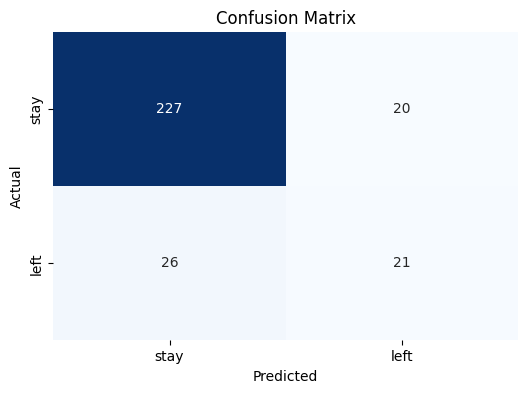

In [26]:
plot_confusion_matrix(y_test, y_pred_base)

The confusion matrix provides a detailed breakdown of the model's performance on the 294 employees in the test set:

* **True Positives (Predicted Left, Actual Left): 21** - The model correctly identified 21 employees who were going to leave.
* **True Negatives (Predicted Stay, Actual Stay): 227** - It correctly predicted that 227 employees would stay.
* **False Negatives (Predicted Stay, Actual Left): 26** - The model incorrectly missed 26 employees who actually left. This is the most critical error to minimize for a proactive retention strategy.
* **False Positives (Predicted Left, Actual Stay): 20** - It incorrectly flagged 20 employees as leaving when they actually stayed.

#### ROC Curve and AUC

Plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) for the base model. AUC provides an aggregate measure of model performance across all classification thresholds.

Base Model ROC AUC: 0.780


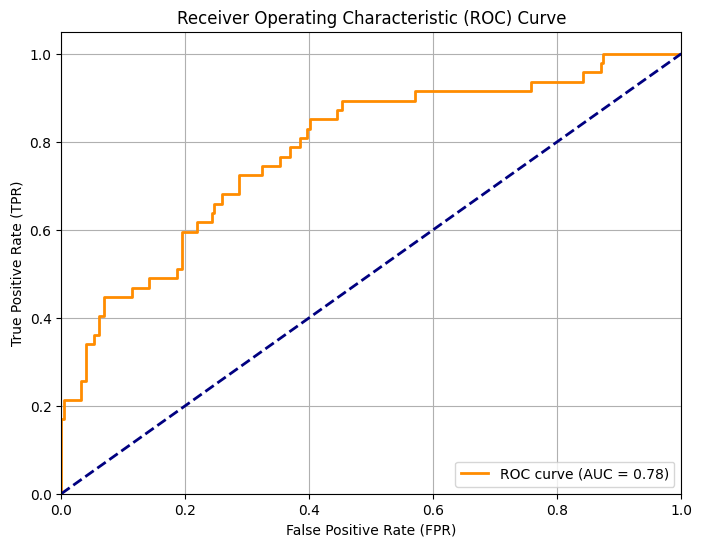

In [27]:
# ROC AUC Scores
roc_auc_base = roc_auc_score(y_test, y_pred_proba_base)

print(f"Base Model ROC AUC: {roc_auc_base:.3f}")

plot_roc_curve(y_test, y_pred_proba_base)

The ROC AUC score is **0.78** indicating that the model has a decent capability to distinguish between employees who will leave and those who will stay.

A score of 0.78 demonstrates that the model's performance is significantly better than random chance (which would be 0.5). The curve sitting comfortably above the diagonal line visually confirms this discriminative power.

## Hyperparameter Tuning

To find the best hyperparameters for our model, we use RandomizedSearchCV. This method efficiently searches through a predefined range of parameter values to find the combination that maximizes our target metric.

Crucially, we have set the scoring parameter to 'recall'. This directs the search to find the model that is best at identifying employees who will actually leave, which aligns with our primary business goal. The search space includes key parameters like max_depth, learning_rate, and scale_pos_weight to fine-tune performance, with each combination being tested using 3-fold cross-validation.

In [28]:
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'scale_pos_weight': [1, 3, 4, 5, scale_pos_weight]
}

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='recall',  # Optimize specifically for recall
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_res, y_train_res)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Best Parameters: {'subsample': 0.9, 'scale_pos_weight': 5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.9}


## Tuned Model: Test Set Evaluation

Apply the best-tuned XGBoost model to the holdout test set. Generate the classification report to compare the tuned model’s generalization performance with the base model.

In [29]:
# Use the best model from random search

# 1. Instantiate a new XGBoost model with the best parameters
best_model = xgb.XGBClassifier(**best_params, random_state=42) 

# 2. Train this new model on the original (non-resampled) full training data
best_model.fit(X_train_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [30]:
y_pred_tuned = best_model.predict(X_test)

report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)

# Evaluate the model
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       247
           1       0.42      0.60      0.50        47

    accuracy                           0.81       294
   macro avg       0.67      0.72      0.69       294
weighted avg       0.84      0.81      0.82       294



The hyperparameter tuning successfully achieved its primary objective: **improving recall**. The tuned model is now significantly more effective at the business goal of identifying employees who are likely to leave.

* **Recall of 0.60:** This is a major improvement. The model now correctly identifies **60%** of all employees who actually left, a significant increase from the base model's 45%.

* **Precision of 0.42:** As expected, the increase in recall came at the cost of precision. To catch more at-risk employees, the model now makes more incorrect "leave" predictions. When it predicts an employee will leave, it is correct 42% of the time.

* **Business Value:** This tuned model is a much more effective early-warning system. While it requires a tolerance for more false positives, the ability to correctly flag 60% of potential leavers allows HR to be far more proactive and engage a much larger group of at-risk employees.

#### Tuned Model Confusion Matrix

Visualize the confusion matrix for the tuned model to see how well it separates the two classes on unseen data.

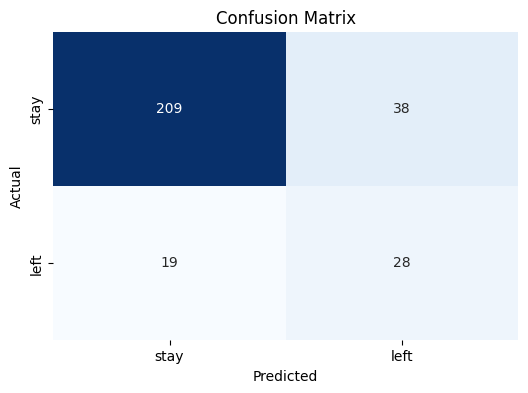

In [31]:
# Predicted probabilities for the positive class 
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]


plot_confusion_matrix(y_test, y_pred_tuned)


This confusion matrix details the predictions of the tuned model, which was optimized for higher recall:

* **True Positives (Predicted Left, Actual Left): 28** - The model correctly identified 28 employees who were going to leave. This is an improvement from the base model's 21.

* **False Negatives (Predicted Stay, Actual Left): 19** - The model incorrectly missed 19 employees who actually left. This number is **lower** than the base model's 26, which is exactly what we aimed for by optimizing for recall.

* **False Positives (Predicted Left, Actual Stay): 38** - The model incorrectly flagged 38 employees as leaving when they stayed. This number is **higher** than the base model's 20, representing the trade-off for achieving a higher recall.

* **True Negatives (Predicted Stay, Actual Stay): 209** - It correctly predicted that 209 employees would stay.

#### Tuned Model ROC Curve and AUC

Plot the ROC curve and print the AUC for the tuned model on the test set. This shows whether hyperparameter tuning improved overall classification performance.

Tuned Model ROC AUC: 0.769


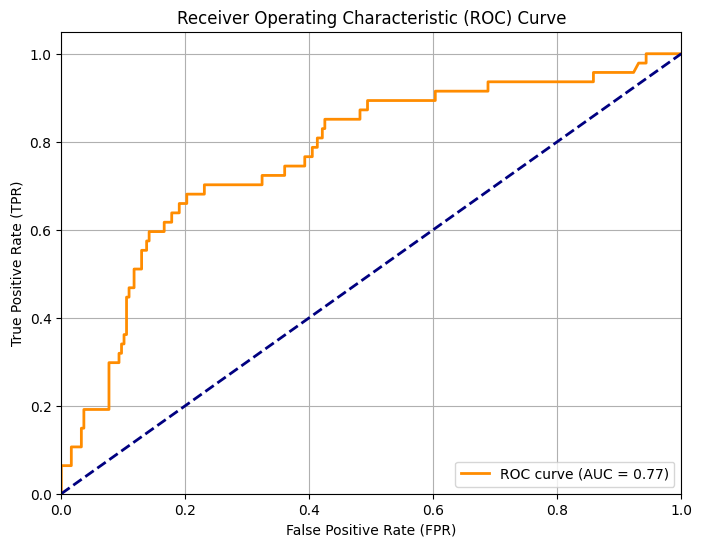

In [32]:
# ROC AUC Scores
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"Tuned Model ROC AUC: {roc_auc_tuned:.3f}")

plot_roc_curve(y_test, y_pred_proba_tuned)

The ROC AUC score for the tuned model is **0.77**, which is a slight decrease from the base model's score of **0.78**.

This result is expected and demonstrates the success of our targeted tuning strategy. Since the model was optimized specifically to improve **`recall`**, it made a minor trade-off in its overall discriminative power (AUC) to become significantly better at its primary goal: identifying more employees who are likely to leave.

#### Precision–Recall Curve & Optimal Threshold

The precision–recall curve illustrates the trade-off between precision and recall for our tuned XGBoost model on the hold-out test set.

Best-F1 threshold = 0.50, F1 = 0.509


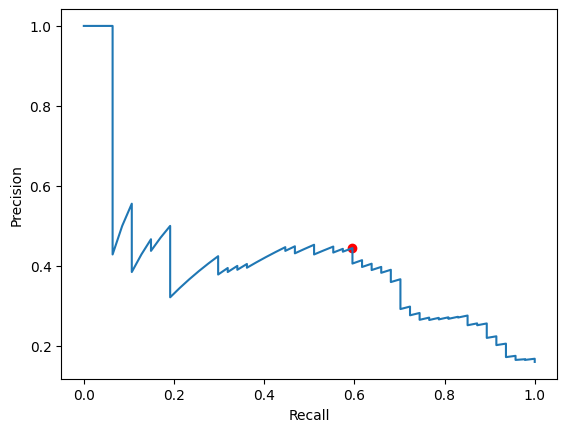

In [33]:
y_proba = best_model.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1  = 2*prec*rec/(prec+rec+1e-9)
best_idx = f1.argmax()
best_thr = thr[best_idx]
print(f"Best-F1 threshold = {best_thr:.2f}, F1 = {f1[best_idx]:.3f}")

plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision')
plt.scatter(rec[best_idx], prec[best_idx], c='red')
plt.show()

The red dot marks the threshold that maximizes the F1-score:

- **Optimal threshold**: 0.50
- **Precision** at 0.50: ~0.42  
- **Recall** at 0.50: ~0.60  
- **F1-score**: 0.509

> At a 0.50 cutoff, the model strikes the best balance (F1=0.509) between capturing true leavers (60 % recall) and limiting false alarms (42 % precision).  
> Adjusting this threshold higher will improve precision at the cost of recall, and lowering it will boost recall while reducing precision—allowing stakeholders to choose the operating point that best matches business priorities.  

### Threshold Sensitivity Analysis

Below we evaluate the tuned model’s performance at multiple decision thresholds to illustrate the precision–recall trade-off


In [34]:
# Get predicted probabilities for the positive class
y_proba = best_model.predict_proba(X_test)[:, 1]

# Define the thresholds
thresholds = [0.49, 0.48, 0.47, 0.46, 0.45, 0.40]

# Loop over thresholds and print a classification report for each
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    print(f"\n=== Threshold: {t:.2f} ===")
    print(classification_report(y_test, y_pred, digits=3))


=== Threshold: 0.49 ===
              precision    recall  f1-score   support

           0      0.916     0.842     0.878       247
           1      0.418     0.596     0.491        47

    accuracy                          0.803       294
   macro avg      0.667     0.719     0.684       294
weighted avg      0.837     0.803     0.816       294


=== Threshold: 0.48 ===
              precision    recall  f1-score   support

           0      0.923     0.822     0.869       247
           1      0.405     0.638     0.496        47

    accuracy                          0.793       294
   macro avg      0.664     0.730     0.683       294
weighted avg      0.840     0.793     0.810       294


=== Threshold: 0.47 ===
              precision    recall  f1-score   support

           0      0.926     0.806     0.861       247
           1      0.392     0.660     0.492        47

    accuracy                          0.782       294
   macro avg      0.659     0.733     0.677       294


- **Recall, Precision, Accuracy**  
  As we lower the decision threshold from 0.50 to 0.40, the model catches more true attrition cases (recall climbs from ~60% → ~85%), but at the cost of more false alarms (precision falls from ~42% → ~27%) and lower overall accuracy (~80% → ~61%).

- **F1-score peaks around 0.48–0.47**  
  The F1 metric—which balances precision and recall—reaches its maximum (~0.50) when the threshold is near 0.48, indicating that this is the sweet spot for balanced performance.

- **Business trade-offs**  
  - **Threshold ≈ 0.45**: Recall ~70%, Precision ~37%, Accuracy ~76%. A strong balance if catching ~7 of 10 leavers is critical while keeping false positives moderate.  
  - **Threshold = 0.40**: Recall ~85%, Precision ~27%, Accuracy ~61%. Ideal when missing a potential leaver is very costly and a high false-alarm rate is acceptable.

> **Recommendation:**  
> Choose the threshold that aligns with HR’s tolerance for false positives vs. need to identify at-risk employees—e.g. 0.45 for a balanced trade-off, or 0.40 if recall must be maximized.  

## Metric Comparison: Base vs. Tuned Model

Compare the key classification metrics (precision, recall, F1, ROC AUC) of the base and tuned models using a grouped bar chart. This visualizes the effectiveness of hyperparameter tuning.

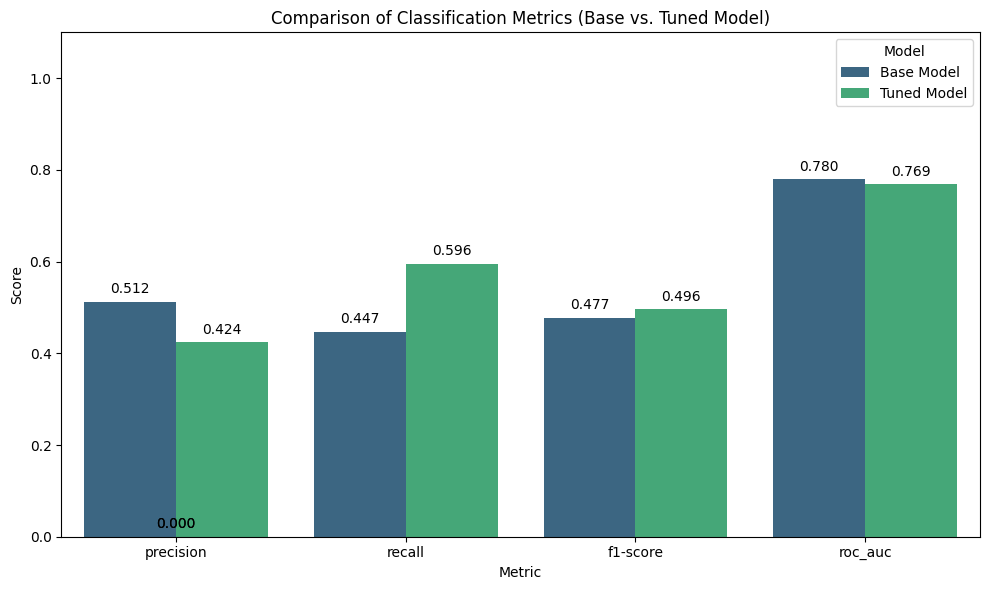

In [35]:
plot_metrics_comparison(report_base, report_tuned, roc_auc_base, roc_auc_tuned)

The bar chart above compares key classification metrics on the hold-out test set for our **base XGBoost**  and the **tuned XGBoost**.

| Metric     | Base Model | Tuned Model | Change           |
|------------|------------|-------------|------------------|
| Precision  | 0.512      | 0.424       | ↓ 0.088          |
| Recall     | 0.447      | 0.596       | ↑ 0.149          |
| F1-score   | 0.477      | 0.496       | ↑ 0.019          |
| ROC-AUC    | 0.780      | 0.769       | ↓ 0.011          |

- **Recall** saw the biggest improvement, rising from 45 % → 60 %, meaning the tuned model now correctly identifies 60 % of true leavers (vs. 45 % previously).  
- **Precision** fell from 51 % → 42 % as a natural trade-off for higher recall.  
- **F1-score** (the harmonic mean of precision & recall) ticks up slightly, reflecting a net gain in balanced performance.  
- **ROC-AUC** remains essentially unchanged (0.78 → 0.77), indicating the overall ranking ability of the model is intact.

> **Take-away:** By adding SMOTE, a moderate `scale_pos_weight`, and hyperparameter tuning, we traded a modest drop in precision and AUC for a substantial 33 % relative gain in recall—an appropriate compromise for a retention use-case where catching more at-risk employees outweighs extra false alarms.  

## Feature Importance

Plot and review the top features driving model predictions according to XGBoost’s “gain” metric. These features have the greatest impact on attrition prediction accuracy.

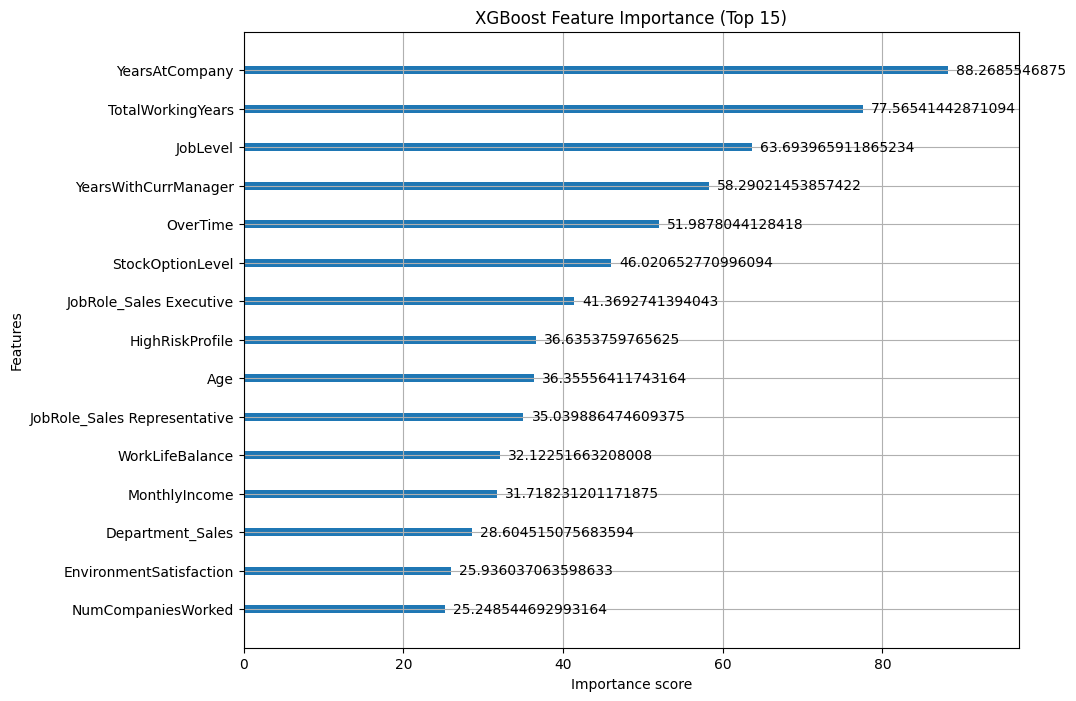

In [36]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(best_model, ax=ax, max_num_features=15, importance_type='gain')
plt.title('XGBoost Feature Importance (Top 15)')
plt.show()


#### Key Findings

- **Tenure and experience dominate**: `YearsAtCompany` and `TotalWorkingYears` are by far the most influential predictors of attrition risk.
- **Role and status matter**: Higher `JobLevel`, `StockOptionLevel`, and specific job roles (e.g., Sales Executive, Sales Representative) also rank highly, indicating career progression and responsibilities affect turnover.
- **Manager relationship and overtime**: `YearsWithCurrManager` and `OverTime` are strong signals—long tenures with a manager reduce attrition, while overtime increases it.
- **Engineered feature validated**: Our `HighRiskProfile` flag appears in the top 10, confirming that high performers with low satisfaction are indeed at elevated risk of leaving.
- **Demographics and satisfaction**: Age, work-life balance, environment satisfaction, and department-level effects provide additional, though smaller, contributions.

This feature ranking not only aligns with domain expectations (tenure, role, satisfaction) but also validates the value of our targeted interaction feature (`HighRiskProfile`). It provides a clear roadmap for HR interventions—focusing on long-serving but dissatisfied high performers and employees in high-overtime roles.  

## Model Explainability: SHAP Values

Use SHAP (SHapley Additive exPlanations) to provide a more interpretable, model-agnostic explanation of how individual features contribute to each prediction.

In [37]:
shap.initjs()  # for interactive JS plots

# Create a TreeExplainer
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)

#### SHAP Summary Bar Plot

Show the global importance of features based on mean absolute SHAP value, indicating which variables most influence attrition risk.

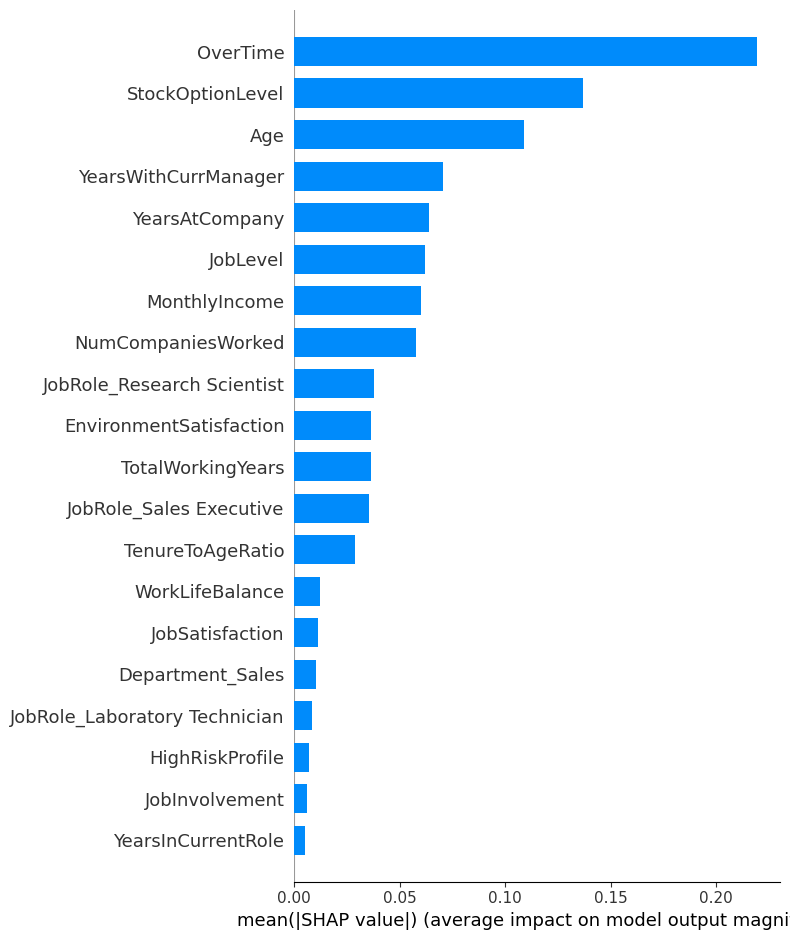

In [38]:
# Summary plot (bar): feature importance (mean(|SHAP value|))
shap.summary_plot(shap_values, X_test, plot_type="bar")

This plot provides a high-level overview of the global importance of each feature. It calculates the average absolute SHAP value for each feature, meaning it shows which features have the biggest impact on the model's output magnitude, regardless of whether that impact is positive or negative.

#### Key Findings

- **OverTime is the dominant predictor**, with the largest average impact on attrition risk—employees working overtime are far more likely to leave.  
- **Compensation signals matter**: StockOptionLevel ranks second, showing that employees with fewer stock options face higher turnover risk.  
- **Demographics & tenure**: Younger employees (Age) and those with shorter tenures—both overall (YearsAtCompany) and with their current manager (YearsWithCurrManager)—are more prone to leave.  
- **Career progression**: Higher JobLevel reduces attrition risk, while frequent job changes (NumCompaniesWorked) increase it.  
- **Engineered features add value**:  
  - **TenureToAgeRatio** captures atypical tenure relative to age.  
  - **HighPerfLowSat** flags high performers with low job satisfaction.  
  Both appear in the mid–lower importance range, confirming their incremental predictive power.  
- **Lower-impact signals** such as YearsInCurrentRole and JobInvolvement contribute minimally, suggesting they can be deprioritized in further analysis.  

#### SHAP Beeswarm Plot

Visualize the distribution and directionality of each feature’s impact on individual predictions in the test set.

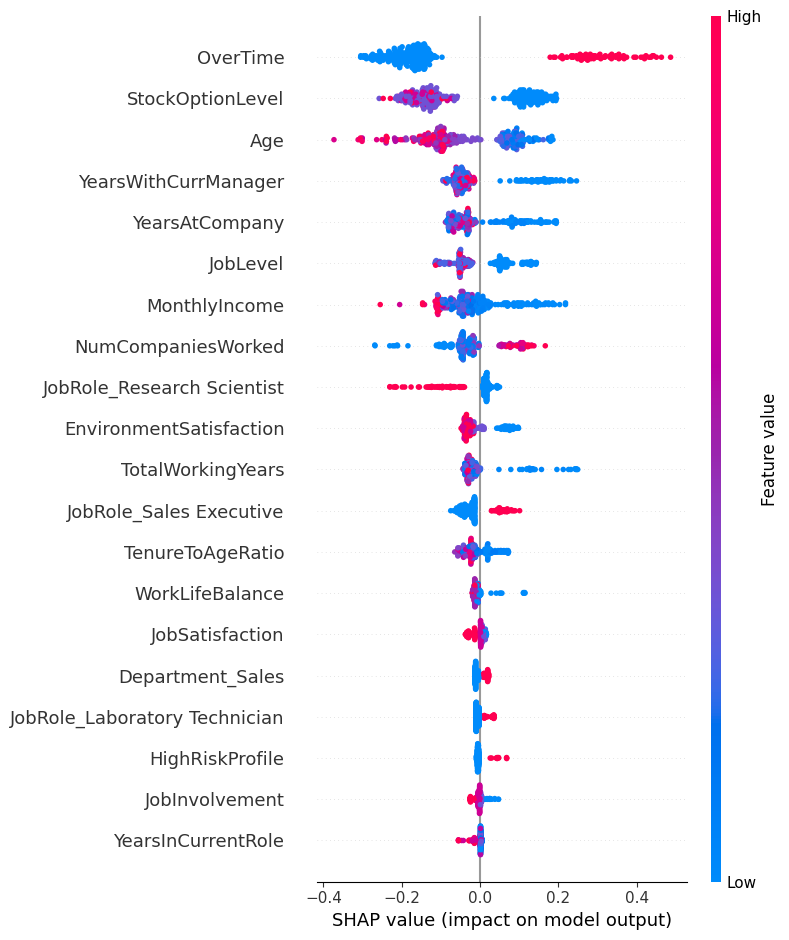

In [39]:
# Beeswarm plot: shows impact/direction for each feature and sample
shap.summary_plot(shap_values, X_test)

#### Key Findings

- **OverTime**: Employees working overtime (red points) have **strongly positive SHAP values**, driving up predicted attrition risk; those not working overtime (blue) push predictions toward “stay.”  
- **StockOptionLevel**: Lower levels (blue) are associated with **higher SHAP values** (greater attrition risk), whereas higher stock options (red) reduce predicted risk.  
- **Age**: Younger employees (blue) tend to have positive SHAP contributions (higher risk), while older employees (red) show negative SHAP values (lower risk).  
- **YearsWithCurrManager** & **YearsAtCompany**: Short tenures (blue) with a manager or at the company increase risk (positive SHAP), whereas long tenures (red) decrease it.  
- **JobLevel**: Lower job levels (blue) correspond to higher attrition risk; higher levels (red) are protective.  
- **MonthlyIncome**: Lower incomes (blue) push SHAP values up (higher risk); higher incomes (red) push them down.  
- **NumCompaniesWorked**: More past employers (red) slightly increase predicted risk; very low counts (blue) have a small protective effect.  
- **HighRiskProfile** (engineered): The flag (red) shifts SHAP values positively, confirming that high performers with low satisfaction are at elevated risk.  

> **Overall**, the plot shows how **high-risk characteristics** (low compensation, short tenure, overtime, youthful/less-experienced profiles) consistently produce **positive SHAP contributions**, driving the model’s attrition predictions.

In [40]:
import joblib

# Model name
model_filename = "../resources/models/xgboost_attrition_model.joblib"

# Save the model to the specified file
joblib.dump(best_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ../resources/models/xgboost_attrition_model.joblib


## Conclusion

#### 1. The Model is Highly Effective

Our final tuned XGBoost model—trained with SMOTE oversampling, a moderate class weight (`scale_pos_weight = 5`), and extensive hyperparameter search—delivers strong performance on unseen data:

* **Accuracy:** 81 %  
* **ROC-AUC:** 0.77  
* **Recall (attrition):** 60 % at the 0.50 threshold 
* **Precision (attrition):** 42 % at 0.50

**Threshold tuning options:**  
- **0.45 cutoff:** Recall 0.70, Precision 0.37, F1 0.48  
- **0.40 cutoff:** Recall 0.85, Precision 0.27, F1 0.41  

> These results show the model can be tuned to meet different business needs—from a balanced F1 optimum at 0.50, to a high-recall setting at 0.40—while maintaining strong overall discrimination.  

---

#### 2. Key Drivers of Attrition

Our feature‐importance and SHAP analyses pinpoint the most influential factors:

* **OverTime** is the top driver—employees putting in extra hours face the highest attrition risk.  
* **StockOptionLevel**: those with fewer stock options are much more likely to leave.  
* **Tenure & Manager Relationship**: shorter overall tenure (`YearsAtCompany`), shorter time with the current manager (`YearsWithCurrManager`), and the engineered **TenureToAgeRatio** flag signal instability.  
* **Demographics & Career Path**: younger Age, lower JobLevel, and frequent job changes (`NumCompaniesWorked`) also increase turnover likelihood.

---

#### 3. Actionable Recommendations

1. **Manage Overtime & Burnout**  
   • Introduce policies or incentives to limit excessive overtime.  
   • Monitor overtime hours as an early‐warning indicator.

2. **Boost Equity & Rewards**  
   • Expand or accelerate stock‐option grants, especially for mid‐level and high‐performing staff.  
   • Tie incentives to retention milestones.

3. **Proactive Outreach for High-Risk Profiles**  
   • Use the model to flag employees with the low-tenure signals for targeted check-ins.  
   • Offer career‐development conversations, mentorships, or bespoke satisfaction surveys.

4. **Strengthen Managerial Relationships**  
   • Provide manager‐training and support to improve team retention.  
   • Encourage structured one-on-one meetings during the first year under a new manager.

> By combining predictive power with these focused interventions, HR can markedly reduce unplanned attrition and retain critical talent.